In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!pip install maldi-nn

In [3]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

## Parameters

In [4]:
from src.config import Config
import dill
from src.pretraining_maldi.load_data_maldi import LoadDataMaldi
from src.molecular_pairs_set import MolecularPairsSet
from torch.utils.data import DataLoader, WeightedRandomSampler
from src.pretraining_maldi.embedder_maldi import EmbedderMaldi
from src.losscallback import LossCallback
import lightning.pytorch as pl
import matplotlib.pyplot as plt

Seed set to 42


In [5]:
data_folder= '/Users/sebas/projects/data/'
dataset_path= data_folder +'merged_gnps_nist_20240207_gnps_nist_janssen_15_millions.pkl'
transformer_path = data_folder + 'best_model_128n_5_layers_20240219_elementwise.ckpt'
results_folder='./notebooks/pretraining/results/'

In [6]:
THRESHOLD_ANALOG=0.7

In [7]:
config=Config()

## Loading data

In [8]:
print("loading file")
# Load the dataset from the pickle file
with open(dataset_path, "rb") as file:
    dataset = dill.load(file)

molecule_pairs_train = dataset["molecule_pairs_train"]
molecule_pairs_val = dataset["molecule_pairs_val"]
molecule_pairs_test = dataset["molecule_pairs_test"]
uniformed_molecule_pairs_test = dataset["uniformed_molecule_pairs_test"]

loading file


In [9]:
spectrums_train=molecule_pairs_train.spectrums
spectrums_val= molecule_pairs_val.spectrums

In [10]:
dataset_train = LoadDataMaldi.from_spectra_to_dataset(spectrums_train, training=True)


Preprocessing all the data ...


263328it [00:04, 56708.84it/s]


Finished preprocessing 
Starting the loading of the data ...
Normalizing intensities
Creating dictionaries


In [11]:
dataset_val = LoadDataMaldi.from_spectra_to_dataset(spectrums_val)

Preprocessing all the data ...


32605it [00:00, 76576.58it/s]

Finished preprocessing 
Starting the loading of the data ...
Normalizing intensities
Creating dictionaries


In [12]:
print("Creating train data loader")
dataloader_train = DataLoader(
    dataset_train, batch_size=config.BATCH_SIZE,  num_workers=10
)
# dataloader_test = DataLoader(dataset_test, batch_size=config.BATCH_SIZE, shuffle=False)

Creating train data loader


In [13]:
def worker_init_fn(
    worker_id,
):  # ensure the dataloader for validation is the same for every epoch
    seed = 42
    torch.manual_seed(seed)
    # Set the same seed for reproducibility in NumPy and Python's random module
    np.random.seed(seed)
    random.seed(seed)


print("Creating val data loader")
dataloader_val = DataLoader(
    dataset_val,
    batch_size=config.BATCH_SIZE,
    worker_init_fn=worker_init_fn,
    num_workers=0,
)

Creating val data loader


In [14]:
sample = next(iter(dataset_train))

In [15]:
sample

{'mz_0': array([100.077835, 105.03234 , 105.32703 , 109.06318 , 115.05264 ,
        127.07392 , 127.13806 , 127.163506, 127.22767 , 127.31855 ,
        127.50355 , 128.06177 , 135.8138  , 141.06786 , 141.5118  ,
        151.05301 , 152.05847 , 157.06145 , 159.04128 , 167.29373 ,
        169.06158 , 173.0575  , 175.07358 , 176.03139 , 181.06256 ,
        181.28778 , 183.04295 , 185.09465 , 194.60608 , 195.07825 ,
        197.05867 , 198.06845 , 199.07408 , 200.05211 , 201.04984 ,
        206.90924 , 209.0571  , 210.95087 , 213.08696 , 215.06824 ,
        215.14525 , 215.40466 , 215.69473 , 217.08334 , 217.1416  ,
        217.19774 , 218.70152 , 219.37096 , 220.743   , 221.84476 ,
        223.07387 , 223.27136 , 224.62965 , 225.05264 , 225.27377 ,
        225.4276  , 226.05986 , 226.12698 , 226.43398 , 227.06769 ,
        227.19067 , 227.25436 , 227.31528 , 227.52637 , 227.74149 ,
        228.73442 , 229.04623 , 229.48248 , 230.1568  , 239.10524 ,
        240.08098 , 241.02905 , 241.0837

In [16]:
sample['mz_0']

array([100.077835, 105.03234 , 105.32703 , 109.06318 , 115.05264 ,
       127.07392 , 127.13806 , 127.163506, 127.22767 , 127.31855 ,
       127.50355 , 128.06177 , 135.8138  , 141.06786 , 141.5118  ,
       151.05301 , 152.05847 , 157.06145 , 159.04128 , 167.29373 ,
       169.06158 , 173.0575  , 175.07358 , 176.03139 , 181.06256 ,
       181.28778 , 183.04295 , 185.09465 , 194.60608 , 195.07825 ,
       197.05867 , 198.06845 , 199.07408 , 200.05211 , 201.04984 ,
       206.90924 , 209.0571  , 210.95087 , 213.08696 , 215.06824 ,
       215.14525 , 215.40466 , 215.69473 , 217.08334 , 217.1416  ,
       217.19774 , 218.70152 , 219.37096 , 220.743   , 221.84476 ,
       223.07387 , 223.27136 , 224.62965 , 225.05264 , 225.27377 ,
       225.4276  , 226.05986 , 226.12698 , 226.43398 , 227.06769 ,
       227.19067 , 227.25436 , 227.31528 , 227.52637 , 227.74149 ,
       228.73442 , 229.04623 , 229.48248 , 230.1568  , 239.10524 ,
       240.08098 , 241.02905 , 241.08377 , 241.55846 , 241.590

In [17]:
target_peak_index=50

In [18]:
sample['mz_0'][target_peak_index]

223.07387

In [19]:
sample['intensity_0'][target_peak_index]

0.00069894525

In [20]:
sample['sampled_mz']

array([100.077835, 105.03234 , 105.32703 , 109.06318 , 115.05264 ,
       127.07392 , 127.13806 , 127.163506, 127.22767 , 127.31855 ,
       127.50355 , 128.06177 , 135.8138  , 141.06786 , 141.5118  ,
       151.05301 , 152.05847 , 157.06145 , 159.04128 , 167.29373 ,
       169.06158 , 173.0575  , 175.07358 , 176.03139 , 181.06256 ,
       181.28778 , 183.04295 , 185.09465 , 194.60608 , 195.07825 ,
       197.05867 , 198.06845 , 199.07408 , 200.05211 , 201.04984 ,
       206.90924 , 209.0571  , 210.95087 , 213.08696 , 215.06824 ,
       215.14525 , 215.40466 , 215.69473 , 217.08334 , 217.1416  ,
       217.19774 , 218.70152 , 219.37096 , 220.743   , 221.84476 ,
       223.07387 , 223.27136 , 224.62965 , 225.05264 , 225.27377 ,
       225.4276  , 226.05986 , 226.12698 , 226.43398 , 227.06769 ,
       227.19067 , 227.25436 , 227.31528 , 227.52637 , 227.74149 ,
       228.73442 , 229.04623 , 229.48248 , 230.1568  , 239.10524 ,
       240.08098 , 241.02905 , 241.08377 , 241.55846 , 241.590

In [21]:
sample['sampled_mz'][target_peak_index]

223.07387

In [22]:
sample['sampled_intensity'][target_peak_index]

0.0006930398

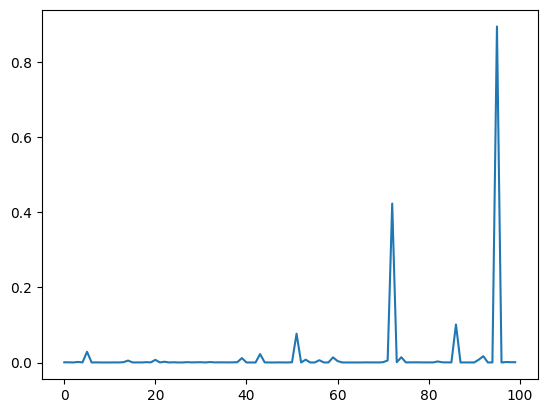

In [23]:
plt.plot(sample['sampled_intensity'], label='sampled')

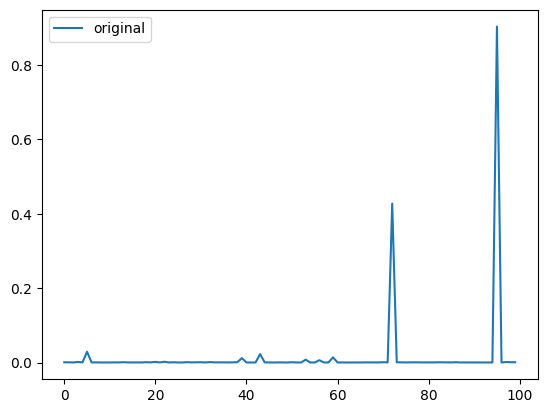

In [24]:

plt.plot(sample['intensity_0'], label = 'original')
plt.legend()

## Instantiate the training

In [25]:
# loss callback
losscallback = LossCallback(file_path=results_folder+f"loss.png")

In [26]:
config.LR

0.0001

In [27]:
print("define model")

model = EmbedderMaldi(
        d_model=int(config.D_MODEL),
        n_layers=int(config.N_LAYERS),
        weights=None,
        lr=config.LR,
    )

define model


In [28]:
# Define the ModelCheckpoint callback
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=results_folder,
    filename="best_model",
    monitor="validation_loss_epoch",
    mode="min",
    save_top_k=1,
)

In [29]:
trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[checkpoint_callback, losscallback],
    enable_progress_bar=True,
    # val_check_interval= config.validate_after_ratio,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /Users/sebas/projects/metabolomics/notebooks/pretraining/results exists and is not empty.

  | Name             | Type                             | Params
----------------------------------------------------------------------
0 | linear           | Linear                           | 16.5 K
1 | linear_output    | Linear                           | 12.9 K
2 | relu             | ReLU                             | 0     
3 | spectrum_encoder | SpectrumTransformerEncoderCustom | 1.7 M 
4 | cross_entropy    | CrossEntropyLoss                 | 0     
5 | cosine_loss      | CosineEmbeddingLoss              | 0     
6 | regression_loss  | MSELoss                          | 0     
7 | dropout          | Dropout                          | 0     
----------------------------------------------------------------------
1.7 M     Trainable params
0         

Sanity Checking: |                                                                                            …

/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
/Users/sebas/projects/metabolomics/src/transformers/spectrum_transformer_encoder_custom.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mass_precursor = torch.tensor(kwargs["precursor_mass"].float())
/Users/sebas/projects/metabolomics/src/transformers/spectrum_transformer_encoder_custom.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  charge_precursor = 

Train loss:
[]
Validation loss
[68.90361022949219]


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Train loss:
[]
Validation loss
[68.90361022949219, 138.41146850585938]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x122f5fec0>
Traceback (most recent call last):
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/multiprocessing/connection.py", line 947, in wait
    ready = selector.

RuntimeError: DataLoader worker (pid 15585) is killed by signal: Interrupt: 2. 

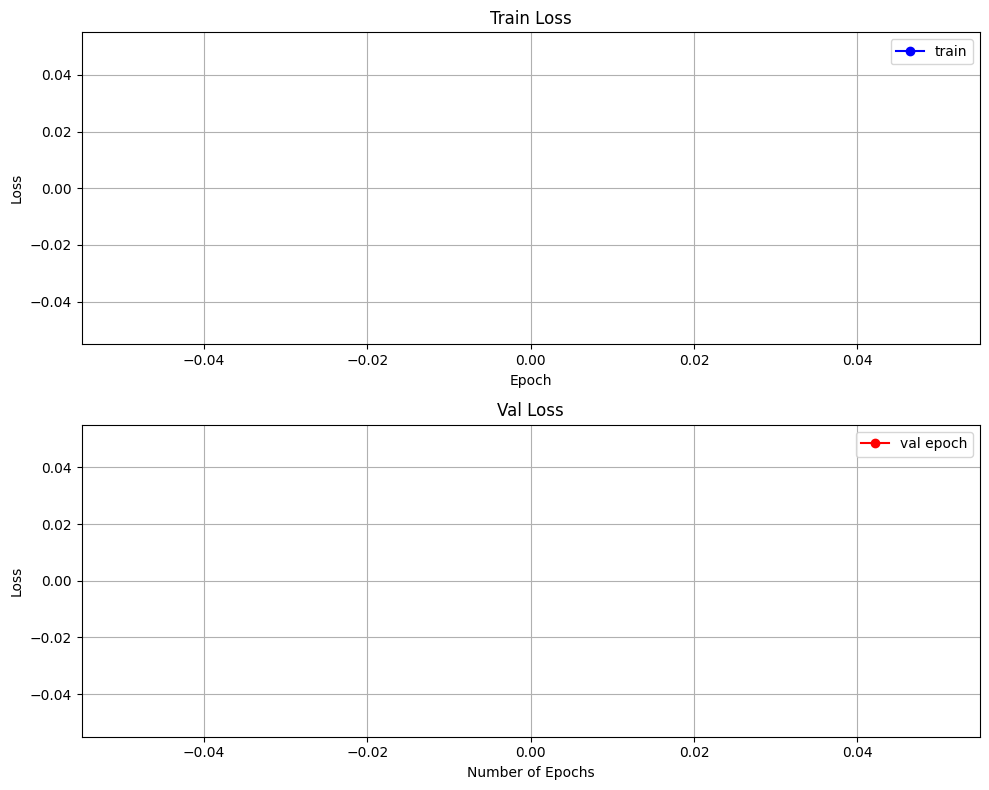

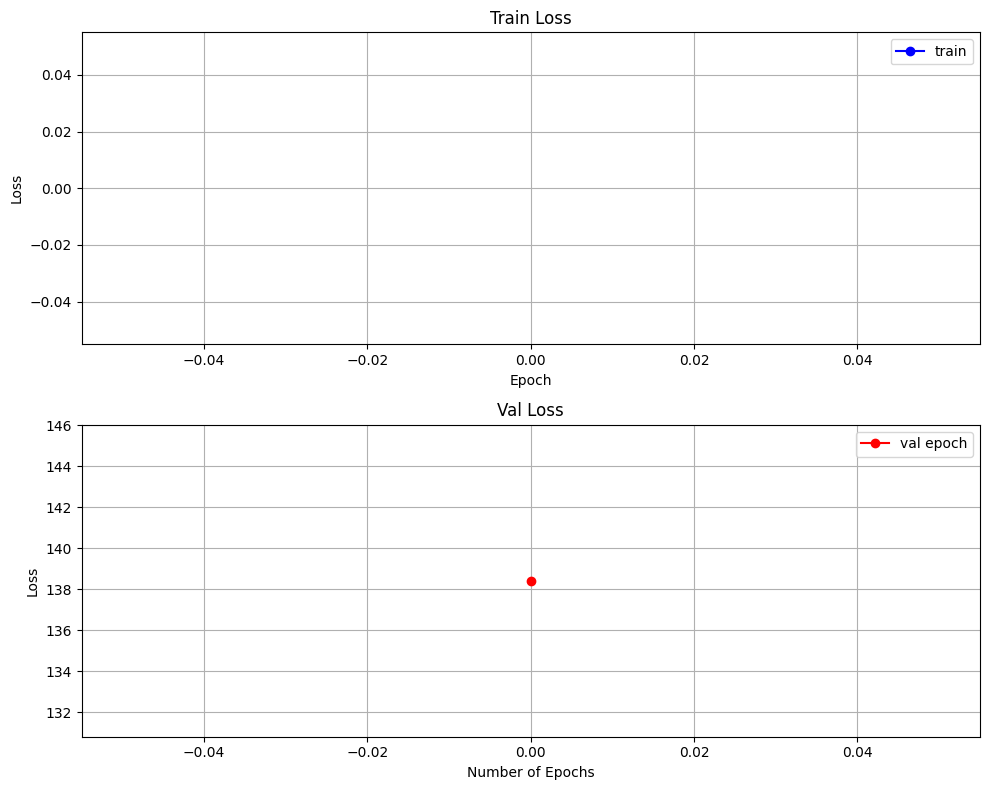

In [30]:

# trainer = pl.Trainer(max_steps=100,  callbacks=[checkpoint_callback, losscallback], enable_progress_bar=enable_progress_bar)
trainer.fit(
    model=model,
    train_dataloaders=(dataloader_train),
    val_dataloaders=dataloader_val,
)


In [ ]:
import numpy as np

In [ ]:
a=np.array([1,2,3,4])

In [ ]:
a[[2,3]]

In [ ]:
from the following 